In [4]:
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:


class NonPerishableDPSolver:
    def __init__(self,
                 over_order_cost: float,
                 under_order_cost: float,
                 fixed_order_cost: float):
        self.over_order_cost = over_order_cost
        self.under_order_cost = under_order_cost
        self.fixed_order_cost = fixed_order_cost

    def cost_function(self, state, order):
        over_order_cost = max(state, 0) * self.over_order_cost
        under_order_cost = -min(state, 0) * self.under_order_cost
        order_cost = self.fixed_order_cost * order
        return over_order_cost + under_order_cost + order_cost

    def act(self, state: float, shipment: float, sales: float) -> Tuple[float, float]:
        resulting_state = state + shipment - sales
        cost = self.cost_function(resulting_state, shipment)
        resulting_state = max(resulting_state, 0)
        return resulting_state, cost
    
    def dp_solve(self, forecasts: np.array):
        T = forecasts.shape[0]
        max_order = forecasts.shape[1]
        
        inventory_max = max_order * (T + 1)
        inventory_max_opt = max_order * T
        
        matrix_size = (T + 1, inventory_max)
        
        explain_array = np.zeros((T + 1, inventory_max, max_order))
        path_array = np.full(matrix_size, -1, dtype=np.int32)
        cost_array = np.full(matrix_size, np.inf)
        cost_array[-1, :] = 0
        
        for t in range(T - 1, -1, -1):
            for inv in range(inventory_max_opt):
                best_order = -1
                best_cost = np.inf
                for order in range(max_order):
                    cost = 0
                    for forecast in range(max_order):
                        forecast_prob = forecasts[t, forecast]
                        state, prob_cost = self.act(inv, order, forecast)
                        resultant_cost = cost_array[t + 1, state]
                        cost += forecast_prob * (prob_cost + resultant_cost)
                    explain_array[t, inv, order] = cost
                    if cost < best_cost:
                        best_cost = cost
                        best_order = order
                path_array[t, inv] = best_order
                cost_array[t, inv] = best_cost
        return explain_array, path_array, cost_array

In [6]:
# 10 days of forecasts, 15 possible values
forecasts = np.random.random((10, 15))
# Normalize to make probabilities:
forecasts = forecasts / np.expand_dims(forecasts.sum(axis=1), 1)
# Solve
solver = NonPerishableDPSolver(2, 6, 0)
explain_array, path_array, cost_array = solver.dp_solve(forecasts)

Text(0.5, 0.98, 'Optimal order per day. each plot is a day, x axis is order number')

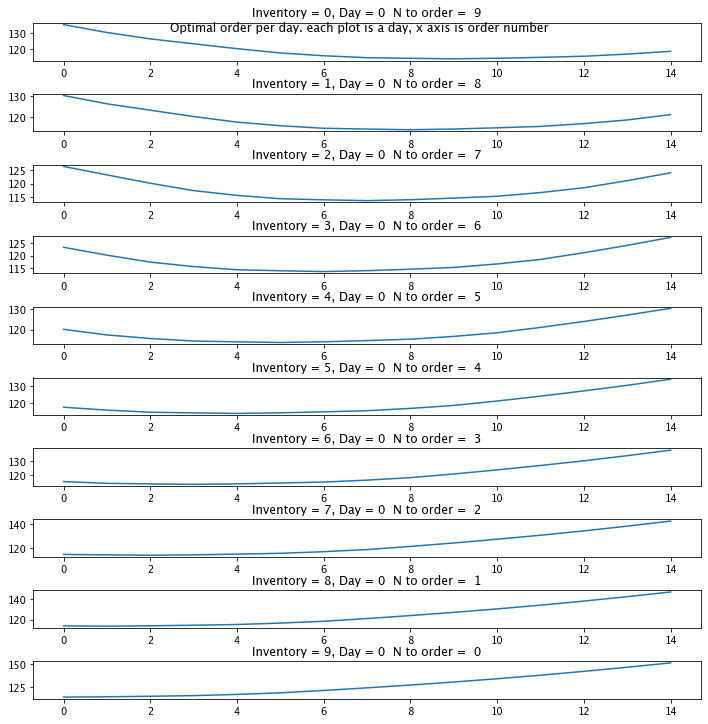

In [7]:
inventory_n =  10
n_orders = np.arange(explain_array.shape[2])
day_n = 0
fig, ax = plt.subplots(inventory_n, figsize=(10,10)) # x axis is day, y axis is inventory
fig.tight_layout()

for inventory in range(inventory_n):
    ax[inventory].plot(explain_array[day_n, inventory, :]) # Time, Inventory, Order
    # print(f" N to order =  {n_orders[np.argmin(explain_array[day_n, inventory, :])]}")
    # ax[inventory_count].set_ax(f'Inventory Count: { inventory_count}')
    ax[inventory].set_title(f"Inventory = {inventory}, Day = {day_n}  N to order =  {n_orders[np.argmin(explain_array[day_n, inventory, :])]}")

fig.suptitle('Optimal order per day. each plot is a day, x axis is order number') 
    

